## Demo#1 - Machine Learning Pipeline for Stock Price Movement Prediction

The purpose of this IPython notebook is to show how stock price movement can be predicted using "stock indicators". Several stock indicators such as exponential moving average (EMA), relative strength index (RSI), stochastic, and William %R can all give clues as to the direction of stock price movement (momentum) using stock data from the past few days/weeks.

This notebook will cover the follow parts:
* [1.) Obtaining the stock data](#1)
* [2.) Labeling stock price movements](#2)
* [3.) Generating stock indicator features](#3)
* [4.) Feature Selection of best stock indicators](#4)
* [5.) Save features and data to SQL](#5)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

<a id="1"></a>
## 1.) Importing Stock Data

Stock data can be obtained free from Yahoo Finance using the yfinance API. For this project, only the last 10-years of daily stock data will be used. The stock indicators only need the open, high, low, close stock information for each day. The rest of the provided data by Yahoo Finance can be dropped.

In [2]:
import yfinance as yf
# 'SPY' is the ETF for S&P 500
ticker = 'SPY'
data = yf.Ticker(ticker)
stock_data = data.history(period='10y')
stock_data.drop(columns=['Dividends', 'Volume', 'Stock Splits'], inplace = True)
stock_data

,Open,High,Low,Close
Date,,,,
2010-08-25,85.81,86.94,85.27,86.62
2010-08-26,87.03,87.14,85.75,86.04
2010-08-27,86.58,87.46,85.28,87.37
2010-08-30,87.14,87.41,86.09,86.10
2010-08-31,85.78,86.65,85.43,86.10
...,...,...,...,...
2020-08-18,338.34,339.10,336.61,338.64
2020-08-19,339.05,339.61,336.62,337.23
2020-08-20,335.36,338.80,335.22,338.28


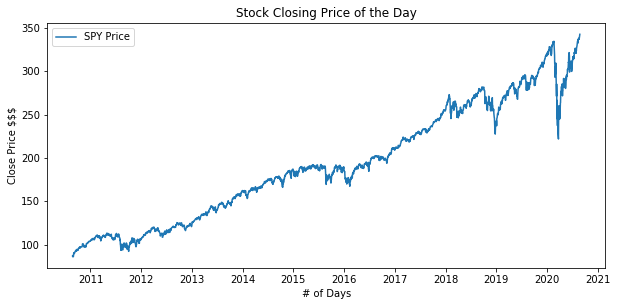

In [3]:
plt.figure(figsize = (10, 4.5))
plt.plot(stock_data['Close'], label = '%s Price'%ticker)
plt.title('Stock Closing Price of the Day')
plt.xlabel('# of Days')
#plt.yscale("log")
plt.ylabel('Close Price $$$')
plt.legend(loc='upper left')
plt.show()

<a id="2"></a>
## 2.) Labeling Stock Price Movement

Currently with the Yahoo Finance data, there is no class labels that tell us which direction the stock price is moving. We need to label each daily data point ourselves by looking at future information. 

For instance, if the past few days of stock prices are increasing and the next few days of stock prices are also declining, then we are looking at a local maxima. However, if the past few days of stock prices are decreasing and the next few days of stock prices are increasing, then we are looking at a local minima. 

By using the rolling average of the past few days/weeks stock price and the rolling average of the next few days/weeks stock price, we can find local minima/maximas by comparing the past and future average values. 

In [4]:
#Length of days to average
avg_length = 25

stock_data['before_avg'] = stock_data['Close'].rolling(window = avg_length).mean()
stock_data['Buy_sig'] = np.ones(len(stock_data['Close']))

for i in range(0,len(stock_data)):
    
    after_avg = 0
    if i == (len(stock_data)-avg_length):
        break
    
    #Get future rolling moving average
    for j in range(0,avg_length):
        after_avg = after_avg + stock_data['Close'].iloc[i+j]
        
    forward_avg = after_avg/avg_length
    
    if stock_data['before_avg'].iloc[i] < forward_avg:
        stock_data['Buy_sig'].iloc[i] = 1
    else:
        stock_data['Buy_sig'].iloc[i] = 0

In [5]:
stock_data['Buy_sig'] = stock_data['Buy_sig'].shift(1, axis = 0)

Shifting all class labels by 1 forward reveals a slightly better pattern

Now the dataframe shows a new column "Buy_sig" which indicates price upward movement ('1') or price downward movement ('0')

In [6]:
stock_data

,Open,High,Low,Close,before_avg,Buy_sig
Date,,,,,,
2010-08-25,85.81,86.94,85.27,86.62,NaN,NaN
2010-08-26,87.03,87.14,85.75,86.04,NaN,0.0
2010-08-27,86.58,87.46,85.28,87.37,NaN,0.0
2010-08-30,87.14,87.41,86.09,86.10,NaN,0.0
2010-08-31,85.78,86.65,85.43,86.10,NaN,0.0
...,...,...,...,...,...,...
2020-08-18,338.34,339.10,336.61,338.64,328.8108,1.0
2020-08-19,339.05,339.61,336.62,337.23,329.4260,1.0
2020-08-20,335.36,338.80,335.22,338.28,330.1256,1.0


In [7]:
stock_train = stock_data.copy()
stock_test = stock_data.copy()

In order to see the downward price movement trends to know when to sell, a sell signal label needs to be added. This is simply the inverse of the buy signal.

In [8]:
stock_train['Sell_sig'] = abs(stock_train['Buy_sig'].iloc[:]-1)

The the binary buy/sell signal now needs to be multipled by the closing price so the price movement signals can be plotted along side the actual closing stock price

In [9]:
stock_train['Buy_price'] = stock_train['Buy_sig']*stock_train['Close']
stock_train['Sell_price'] = stock_train['Sell_sig']*stock_train['Close']
#stock_data.dropna(inplace = True, axis = 0)

In [10]:
stock_train

,Open,High,Low,Close,before_avg,Buy_sig,Sell_sig,Buy_price,Sell_price
Date,,,,,,,,,
2010-08-25,85.81,86.94,85.27,86.62,NaN,NaN,NaN,NaN,NaN
2010-08-26,87.03,87.14,85.75,86.04,NaN,0.0,1.0,0.00,86.04
2010-08-27,86.58,87.46,85.28,87.37,NaN,0.0,1.0,0.00,87.37
2010-08-30,87.14,87.41,86.09,86.10,NaN,0.0,1.0,0.00,86.10
2010-08-31,85.78,86.65,85.43,86.10,NaN,0.0,1.0,0.00,86.10
...,...,...,...,...,...,...,...,...,...
2020-08-18,338.34,339.10,336.61,338.64,328.8108,1.0,0.0,338.64,0.00
2020-08-19,339.05,339.61,336.62,337.23,329.4260,1.0,0.0,337.23,0.00
2020-08-20,335.36,338.80,335.22,338.28,330.1256,1.0,0.0,338.28,0.00


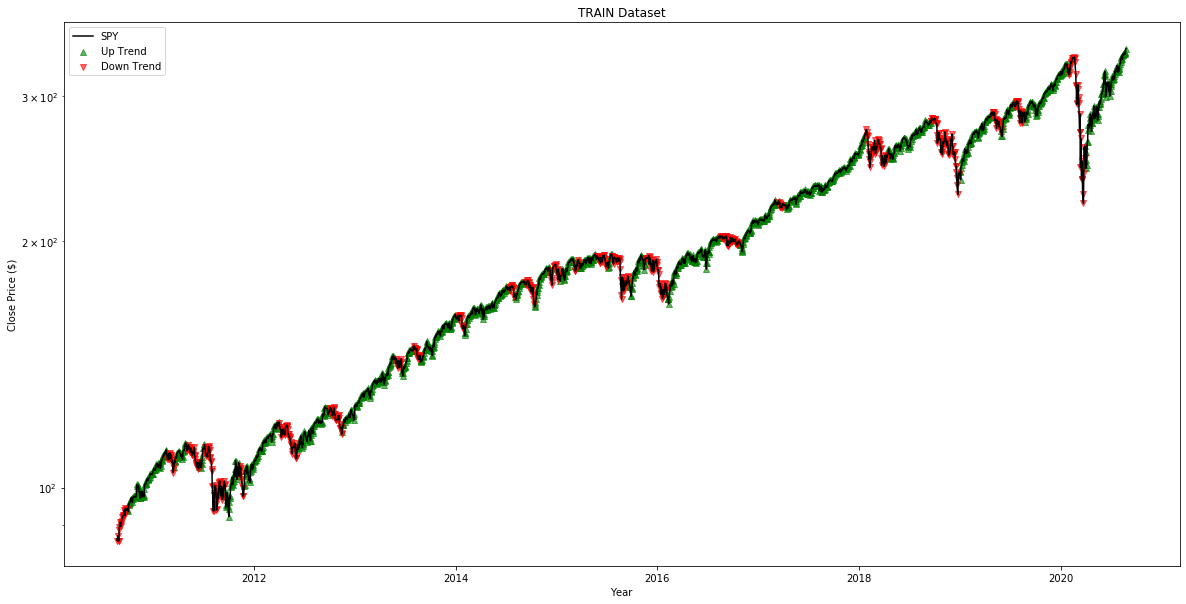

In [11]:
import datetime

plt.figure(figsize = (20, 10))
plt.plot(stock_train['Close'], label = ticker, color = 'black')
#Plot additional scatter points for buy and sell signals
plt.scatter(stock_train.index, stock_train['Buy_price'], label ='Up Trend', marker = '^', color = 'green', alpha = 0.6)
plt.scatter(stock_train.index, stock_train['Sell_price'], label ='Down Trend', marker = 'v', color = 'red', alpha = 0.6)
plt.title('TRAIN Dataset')
plt.xlabel('Year')
plt.yscale("log")
plt.ylabel('Close Price ($)')
plt.legend(loc='upper left')
plt.rcParams.update({'font.size': 16})
#plt.savefig('ML_Train_SPY.jpg')
plt.show()

<a id="3"></a>
## 3.) Generating Stock Indicator Features

The stock price itself does not reveal any trends or provide any information on price movements since every stock has a different price value. Using stock indicators however can provide more information since these are tools used by many professional traders.

The stock indicators used in this project are:

* Exponential Moving Average (EMA)
* Relative Strength Index (RSI)
* Williams %R
* Stochastic Oscillator

These are primarily momentum indicators and there are other non-momentum indicators but for the limited time frame of this project, only 4 indicators will be tested

### Exponential Moving Average (EMA)

EMA can be calculated using the following formula:

EMA = CurrentPrice * (2/(1+N))  + PreviousEMA * (1-(2/(1+N)))

The (2/(1+N)) is the smoothing factor and 'N' is the number of days to smooth. We are not interested in the actual EMA price but whether the EMA is above/below the stock price. If the EMA is below the stock price, it is most likely a downtrend and if the EMA is above the stock price, it is most likely moving in an uptrend.

In [12]:
for n in range(3,avg_length*2, 2):
    ema = stock_train['Close'].iloc[0]
    ema_list = [ema]
 
    for i in range(1, len(stock_train['Close'])):
        ema = stock_train['Close'].iloc[i]*(2/(1+n)) + ema*(1-(2/(1+n)))
        ema_list.append(ema)
    stock_train['EMA'] = ema_list

    #Compare if above or below ema
    slope_ema = [1]
    for j in range(1, len(ema_list)):
        
        if ema_list[j]<stock_train['Close'].iloc[j]:
            slope_ema.append(1)
        else:
            slope_ema.append(0)
            
    stock_train['ema_%d'%n]= slope_ema
stock_train.drop(['EMA'], inplace = True, axis = 1)

### Relative Strength Index (RSI)

RSI can be defined as:
<Br>*A momentum indicator used in technical analysis that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock or other asset.*

More about RSI can be learned from here: [Learn RSI](https://www.investopedia.com/terms/r/rsi.asp#:~:text=The%20relative%20strength%20index%20(RSI)%20is%20a%20momentum%20indicator%20used,a%20stock%20or%20other%20asset)

In [13]:
#Get RSI indicators

change_gains = [0]
change_loss = [0]
for i in range(1, len(stock_train)):
    change = stock_train['Close'].iloc[i]-stock_train['Close'].iloc[i-1]
    change_gains.append(change if change>0 else 0)
    change_loss.append(abs(change) if change<0 else 0)

stock_train['change_gains'] = change_gains
stock_train['change_loss'] = change_loss

#The RSI window range
for i in range(3, 31, 1):
    x = stock_train['change_gains'].rolling(window = i).mean()/stock_train['change_loss'].rolling(window = i).mean()
    rsi = 100-(100/(1+x))+.001
    stock_train['RSI_%d'%i] = rsi

### Williams %R

William %R can be defined as:
<Br>*A type of momentum indicator that moves between 0 and -100 and measures overbought and oversold levels. The Williams %R may be used to find entry and exit points in the market.*

More about William %R and it's calculations can be learned from here: [Learn Williams %R](https://www.investopedia.com/terms/w/williamsr.asp)

In [14]:
#Now get Williams %R indicator

for i in range(3, avg_length*4, 2):
    High_high = stock_train['High'].rolling(window = i).max()
    Low_low = stock_train['Low'].rolling(window = i).min()
    
    stock_train['Will_R_%d'%i] = -100*(High_high - stock_train['Close'])/(High_high-Low_low)

### Stochastic Oscillator

Stochastic Oscillator can be defined as:
<Br>*A momentum indicator comparing a particular closing price of a security to a range of its prices over a certain period of time.*

More about Stochastic Oscillator and it's calculations can be learned from here: [Learn Stochastic Oscillator](https://www.investopedia.com/terms/s/stochasticoscillator.asp)

In [15]:
#Now get Stochastic indicator

for i in range(3, 35, 1):
    High_price = stock_train['Close'].rolling(window = i).max()
    Low_price = stock_train['Close'].rolling(window = i).min()
    
    stock_train['Stochastic_%d'%i] = (stock_train['Close']-Low_price)/(High_price-Low_price)

Now the following dataframe contains open, high, low, close, buy/sell signals, and all stock momentum indicators with varying periods. There should be >100 features in the dataframe now.

In [16]:
stock_train.dropna(axis = 0, inplace=True)
stock_train.reset_index(inplace = True)
stock_train

,Date,Open,High,Low,Close,before_avg,Buy_sig,Sell_sig,Buy_price,Sell_price,...,Stochastic_25,Stochastic_26,Stochastic_27,Stochastic_28,Stochastic_29,Stochastic_30,Stochastic_31,Stochastic_32,Stochastic_33,Stochastic_34
0,2011-01-13,106.29,106.34,105.81,106.07,103.9352,1.0,0.0,106.07,0.0,...,0.960177,0.963415,0.965974,0.966292,0.966292,0.967332,0.973451,0.979661,0.979661,0.979661
1,2011-01-14,105.92,106.87,105.85,106.84,104.1396,1.0,0.0,106.84,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,2011-01-18,106.74,107.12,106.62,107.02,104.3276,1.0,0.0,107.02,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,2011-01-19,106.93,107.04,105.69,105.97,104.4708,1.0,0.0,105.97,0.0,...,0.790419,0.790419,0.790419,0.801512,0.815466,0.826733,0.828151,0.828151,0.832803,0.860927
4,2011-01-20,105.73,106.10,105.05,105.83,104.6048,1.0,0.0,105.83,0.0,...,0.762475,0.762475,0.762475,0.762475,0.775047,0.790861,0.803630,0.805237,0.805237,0.810510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2414,2020-08-18,338.34,339.10,336.61,338.64,328.8108,1.0,0.0,338.64,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2415,2020-08-19,339.05,339.61,336.62,337.23,329.4260,1.0,0.0,337.23,0.0,...,0.921008,0.921008,0.928499,0.940756,0.940756,0.941880,0.941880,0.943282,0.943282,0.946611
2416,2020-08-20,335.36,338.80,335.22,338.28,330.1256,1.0,0.0,338.28,0.0,...,0.979730,0.979832,0.979832,0.981744,0.984874,0.984874,0.985161,0.985161,0.985519,0.985519
2417,2020-08-21,337.92,339.72,337.55,339.48,330.8360,1.0,0.0,339.48,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<a id="4"></a>
## 4.) Feature Selection of Best Stock Indicators

With over 100 feature variables, we need to select the stock indicators with the highest correlation/importance to the class label.

One option is to use the "Forward Feature Selection" (FFS) technique. This technique will test all features one at a time and select the feature with the highest machine learning accuracy. FFS will use the previous feature while selecting the next feature with the highest machine learning accuracy and this process is repeated until the accuracy score no longer increases.

Any machine learning algorithm can be used for this process. Since the class labels are binary values, Logistic Regression is a great and fast machine learning choice. However, Random Forest Classification is also effective if the optimal hyperparameters are found. 

In [17]:
#First assign the "y_train" variable as the class label
y_train = stock_train['Buy_sig'].values

In [18]:
stock_test = stock_train.copy()

In [19]:
stock_train.drop(['change_gains','change_loss'], inplace = True, axis = 1)

In [20]:
stock_train.drop(['Date','Close', 'Open', 'High', 'Low', 'before_avg','Buy_price', 'Sell_price','Buy_sig', 'Sell_sig'], inplace = True, axis = 1)

Now our stock_train dataframe only contains stock indicators are feature variables

In [21]:
stock_train.columns

Index(['ema_3', 'ema_5', 'ema_7', 'ema_9', 'ema_11', 'ema_13', 'ema_15',
       'ema_17', 'ema_19', 'ema_21',
       ...
       'Stochastic_25', 'Stochastic_26', 'Stochastic_27', 'Stochastic_28',
       'Stochastic_29', 'Stochastic_30', 'Stochastic_31', 'Stochastic_32',
       'Stochastic_33', 'Stochastic_34'],
      dtype='object', length=133)

In [22]:
# from sklearn.ensemble import RandomForestClassifier

# reg = RandomForestClassifier(n_estimators=150, n_jobs=-1,
#                             min_samples_split =50, random_state = 42)

In [23]:
from sklearn.linear_model import LogisticRegression

reg = LogisticRegression(max_iter = 10000, tol=0.0001, C=1, random_state = 42, n_jobs = -1)

In this example, Logistic Regression is used as the machine learning algorithm choice.

In FFS, every iteration will involve 5-fold Cross-Validation to obtain a mean accuracy value. This is more representative of the prediction accuracy for the entire 10-year stock data period.

In [24]:
def eval_model(reg, scaled_x, y):
    accuracies = cross_val_score(estimator = reg, X = scaled_x, y = y, cv = 5, n_jobs = -1)
    return accuracies.mean()

In [25]:
#This function drops one feature at a time until accuracy no longer increases after 2 consecutive iterations or there are at least 10 feature indicators.

def forward_feature_selection(stock_train, y_train):
    max_best_perc = 0
    consecutive_iter = 0
    feature_set = []
    final_list = []
    final_features = []
    
    for num in range(stock_train.shape[1]):
        metric_list = []
        
        for feature in stock_train.columns:
  
            if feature not in feature_set:
        
                #Create a new f_set each loop
                f_set = feature_set.copy()
                f_set.append(feature)
                
                x = stock_train[f_set]
                
                len_test2 = len_test # of trading days
                len_x_train = x.shape[1] #The number of features in x_train
                
                #Prep x,y trains
                x_train_eval = x

                train_scaler_eval = StandardScaler()
                scaled_x_train_eval = train_scaler_eval.fit_transform(x_train_eval)
                
                result_list = (eval_model(reg, scaled_x_train_eval, y_train), feature)
            
                metric_list.append(result_list)
        
        metric_list.sort(key=lambda x : x[0], reverse = True) # In case metric follows "the more, the merrier"
        
      # print(metric_list)
        best_perc = np.round(metric_list[0][0], 4)
        
        if len(metric_list)>1:
            feature_set.append(metric_list[0][1])
            f_set = feature_set.copy()
            final_list.append((best_perc, f_set))
        
            #Save the best metric feature in temp
            temp = stock_train[str(metric_list[0][1])]
        
            #Remove all other features related to best metric one
            remove_str = str(metric_list[0][1])
            x = stock_train.columns.str.startswith(remove_str)
            stock_train = stock_train.drop(stock_train.columns[x], axis = 1)

            print((best_perc, f_set))
        
            if best_perc > max_best_perc:
                max_best_perc = best_perc
                
            stock_train[str(metric_list[0][1])] = temp
            if stock_train.shape[1] < 3:
                break
        
        if len(final_list)>=10:
            break
            
        elif best_perc < max_best_perc:
            consecutive_iter += 1
            if consecutive_iter == 2:
                break
        
    final_list.sort(key = lambda x : x[0], reverse = True)
    return final_list

In [26]:
results = forward_feature_selection(stock_train, y_train)

(0.7892, ['RSI_19'])
(0.7995, ['RSI_19', 'Stochastic_7'])
(0.8012, ['RSI_19', 'Stochastic_7', 'RSI_18'])
(0.802, ['RSI_19', 'Stochastic_7', 'RSI_18', 'ema_37'])
(0.8028, ['RSI_19', 'Stochastic_7', 'RSI_18', 'ema_37', 'Will_R_81'])
(0.8032, ['RSI_19', 'Stochastic_7', 'RSI_18', 'ema_37', 'Will_R_81', 'ema_33'])
(0.8041, ['RSI_19', 'Stochastic_7', 'RSI_18', 'ema_37', 'Will_R_81', 'ema_33', 'ema_7'])
(0.8037, ['RSI_19', 'Stochastic_7', 'RSI_18', 'ema_37', 'Will_R_81', 'ema_33', 'ema_7', 'ema_5'])
(0.8041, ['RSI_19', 'Stochastic_7', 'RSI_18', 'ema_37', 'Will_R_81', 'ema_33', 'ema_7', 'ema_5', 'Will_R_3'])
(0.8032, ['RSI_19', 'Stochastic_7', 'RSI_18', 'ema_37', 'Will_R_81', 'ema_33', 'ema_7', 'ema_5', 'Will_R_3', 'ema_35'])


In [27]:
#Sort results output by highest accuracy
for i, j in results:
    print(i,j)

0.8041 ['RSI_19', 'Stochastic_7', 'RSI_18', 'ema_37', 'Will_R_81', 'ema_33', 'ema_7']
0.8041 ['RSI_19', 'Stochastic_7', 'RSI_18', 'ema_37', 'Will_R_81', 'ema_33', 'ema_7', 'ema_5', 'Will_R_3']
0.8037 ['RSI_19', 'Stochastic_7', 'RSI_18', 'ema_37', 'Will_R_81', 'ema_33', 'ema_7', 'ema_5']
0.8032 ['RSI_19', 'Stochastic_7', 'RSI_18', 'ema_37', 'Will_R_81', 'ema_33']
0.8032 ['RSI_19', 'Stochastic_7', 'RSI_18', 'ema_37', 'Will_R_81', 'ema_33', 'ema_7', 'ema_5', 'Will_R_3', 'ema_35']
0.8028 ['RSI_19', 'Stochastic_7', 'RSI_18', 'ema_37', 'Will_R_81']
0.802 ['RSI_19', 'Stochastic_7', 'RSI_18', 'ema_37']
0.8012 ['RSI_19', 'Stochastic_7', 'RSI_18']
0.7995 ['RSI_19', 'Stochastic_7']
0.7892 ['RSI_19']


### Optimize Hyperparameters?

Although we found the best feature indicators to obtain the highest accuracy, is it still possible to push the accuracy slightly more using GridSearch to find the best hyperparameters?
<Br>Let's find out by creating a new dataframe with the best feature indicators

In [31]:
top_feat_train = pd.DataFrame(stock_train, columns =  results[0][1])

In [34]:
train_scaler = StandardScaler()

In [35]:
from sklearn.model_selection import GridSearchCV
parameters = [{'max_iter':[100,1000,10000,100000],'tol':[0.000001, 0.00001, 0.0001, 0.001, 0.01],'C':np.arange(0.2,2,0.2)}]
gridsearch = GridSearchCV(estimator = reg, param_grid = parameters, scoring = 'accuracy', cv = 5, n_jobs = -1)
gridsearch = gridsearch.fit(train_scaler.fit_transform(top_feat_train.values), y_train)
best_accuracy = gridsearch.best_score_
print('Accuracy of optimized gridsearch:\n', best_accuracy)
best_parameters = gridsearch.best_params_
print(best_parameters)

Accuracy of optimized gridsearch:
 0.8044838560648836
{'C': 1.2, 'max_iter': 100, 'tol': 1e-06}


So now we found the optimal logistic regression hyperparameters using GridSearch. However, it looks like the accuracy was only able to increase from 0.8041 to 0.8045 which is negligible.

<a id="5"></a>
## 5.) Save Features and Data to SQL

Now that we found the best indicator features, we should save these features so that we do not have to redo Forward Feature Selection again. The best way to do this is to store the data in an SQL table.

SQLite is integrated with Python and is a convenient choice. But first, we need to include the buy signal class label data (y_train) as well as the closing price and date of the stock

In [36]:
optimized = results.copy()
optimized[0][1].append('Close')
optimized[0][1].append('Date')

In [37]:
len_features = len(results[0][1])

In [38]:
stock_save = stock_test[optimized[0][1]]

In [39]:
stock_save['buy_sig'] = y_train

In [40]:
stock_save

,RSI_19,Stochastic_7,RSI_18,ema_37,Will_R_81,ema_33,ema_7,Close,Date,buy_sig
0,80.493091,0.864662,80.108527,1,-2.049470,1,1,106.07,2011-01-13,1.0
1,82.520685,1.000000,81.804279,1,-0.204638,1,1,106.84,2011-01-14,1.0
2,82.325841,1.000000,80.285192,1,-0.670691,1,1,107.02,2011-01-18,1.0
3,67.665671,0.500000,66.038736,1,-8.161817,1,0,105.97,2011-01-19,1.0
4,64.616385,0.308140,66.142732,1,-9.155429,1,0,105.83,2011-01-20,1.0
...,...,...,...,...,...,...,...,...,...,...
2414,65.954413,1.000000,73.744186,1,-0.683405,1,1,338.64,2020-08-18,1.0
2415,70.724207,0.758562,75.271479,1,-3.509289,1,1,337.23,2020-08-19,1.0
2416,76.048904,0.801105,74.244400,1,-1.961073,1,1,338.28,2020-08-20,1.0
2417,75.202488,1.000000,80.305535,1,-0.353305,1,1,339.48,2020-08-21,1.0


### Dataframe to SQL

In [42]:
from sqlalchemy import create_engine

file_name = 'All_stock'
table_name = 'SPY_LogitReg'

engine = create_engine('sqlite:///' + file_name +'.sql', echo=False)
conn = engine.connect()
db = stock_save.to_sql(table_name, con=engine)
conn.close()